In [1]:
# Import libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, learning_curve

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

RSEED=42

In [2]:
# Load the final DataFrame from EDA_upto_2000.ipynb
df = pd.read_pickle('../data/final_df_2000.pkl')
df.head()

,serviceCharge,heatingType,newlyConst,balcony,pricetrend,totalRent,yearConstructed,firingTypes,hasKitchen,cellar,livingSpace,condition,lift,typeOfFlat,geo_plz,noRooms,floor,garden
0,245.0,Central Heating,False,False,4.62,840.00,1965.0,Oil,False,True,86.00,well_kept,False,ground_floor,44269,4.0,1.0,True
2,255.0,Electric Heating,True,True,2.72,1300.00,2019.0,Other_imputed,False,True,83.80,first_time_use,True,apartment,1097,3.0,3.0,False
4,138.0,Central Heating,False,True,2.46,903.00,1950.0,Gas,False,False,84.97,refurbished,False,apartment,28213,3.0,1.0,False
6,70.0,Central Heating,False,False,1.01,380.00,1881.0,Other_imputed,False,True,62.00,fully_renovated,False,Other_imputed,9599,2.0,1.0,True
7,88.0,Central Heating,False,True,1.89,584.25,1959.0,Gas,False,True,60.30,Other,False,ground_floor,28717,3.0,2.0,False


In [4]:
# Initial Data Cleaning: Convert boolean to int
bool_columns = ['newlyConst', 'balcony', 'hasKitchen', 'cellar', 'lift', 'garden']
df[bool_columns] = df[bool_columns].astype(int)

In [5]:
# Define features and target
X = df.drop('totalRent', axis=1)
y = df['totalRent']

In [6]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in bool_columns]


In [7]:
# Preprocessing Pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [8]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'  # Keep bool columns as they are already numeric
)

In [9]:
# Define individual models
lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso(random_state=42))
])

rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42, n_jobs=-1))
])

In [10]:
# Hyperparameter tuning for some models (using GridSearchCV)
param_grid_lasso = {
    'model__alpha': [0.01, 0.1, 1, 10, 100, 1000]
}

param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

param_grid_gb = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [3, 5, 7, 9]
}

param_grid_xgb = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [3, 5, 7, 9]
}

In [11]:
# Initialize GridSearchCV for models with updated parameter grids
grid_search_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')


GridSearchCV exhaustively searches over a specified parameter grid to find the best hyperparameters for the model.

In [12]:
# Fit models to training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)




In [13]:
grid_search_lasso.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['serviceCharge',
                                                                          'pricetrend',
                                                                          'yearConstructed',
                                                                          'livingSpace',
                                                                          'geo_plz',
                                                                          'noRooms',
                                                                          'floor']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['heatingType',
                                                                          'firingTypes',
                                                                          'condition',
                                                                          'typeOfFlat'])])),
                                       ('model', Lasso(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.01, 0.1, 1, 10, 100, 1000]},
             scoring='neg_mean_squared_error')

In [14]:
grid_search_rf.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['serviceCharge',
                                                                          'pricetrend',
                                                                          'yearConstructed',
                                                                          'livingSpace',
                                                                          'geo_plz',
                                                                          'noRooms',
                                                                          'floor']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['heatingType',
                                                                          'firingTypes',
                                                                          'condition',
                                                                          'typeOfFlat'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20, 30],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [15]:
grid_search_gb.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['serviceCharge',
                                                                          'pricetrend',
                                                                          'yearConstructed',
                                                                          'livingSpace',
                                                                          'geo_plz',
                                                                          'noRooms',
                                                                          'floor']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['heatingType',
                                                                          'firingTypes',
                                                                          'condition',
                                                                          'typeOfFlat'])])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'model__max_depth': [3, 5, 7, 9],
                         'model__n_estimators': [100, 200, 300, 400]},
             scoring='neg_mean_squared_error')

In [16]:
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['serviceCharge',
                                                                          'pricetrend',
                                                                          'yearConstructed',
                                                                          'livingSpace',
                                                                          'geo_plz',
                                                                          'noRooms',
                                                                          'floor']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['heatingType'...
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=-1,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'model__max_depth': [3, 5, 7, 9],
                         'model__n_estimators': [100, 200, 300, 400]},
             scoring='neg_mean_squared_error')

In [17]:
# Best estimators
best_lasso = grid_search_lasso.best_estimator_
best_rf = grid_search_rf.best_estimator_
best_gb = grid_search_gb.best_estimator_
best_xgb = grid_search_xgb.best_estimator_

In [18]:
# Create VotingRegressor
voting_regressor = VotingRegressor(estimators=[
    ('lr', lr),
    ('lasso', best_lasso),
    ('rf', best_rf),
    ('gb', best_gb),
    ('xgb', best_xgb)
])

using an ensemble method by combining multiple models (Lasso, Random Forest, Gradient Boosting, XGBoost) into a single VotingRegressor.

In [19]:
# Fit VotingRegressor to the training data
voting_regressor.fit(X_train, y_train)

VotingRegressor(estimators=[('lr',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['serviceCharge',
                                                                                'pricetrend',
                                                                                'yearConstructed',
                                                                                'livingSpace',
                                                                                'geo_plz',
                                                                                'noRooms',
                                                                                'floor']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['heatin...
                                                           gamma=None,
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=0.1,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=9,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=400,
                                                           n_jobs=-1,
                                                           num_parallel_tree=None,
                                                           random_state=42, ...))]))])

In [20]:
# Make predictions
y_pred = voting_regressor.predict(X_test)

In [21]:
# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)

In [22]:
# Print the RMSE
print(f"Root Mean Squared Error of Voting Regressor: {rmse}")

Root Mean Squared Error of Voting Regressor: 129.12785790951307


In [23]:
# Individual model RMSEs for comparison
rmse_lr = mean_squared_error(y_test, lr.fit(X_train, y_train).predict(X_test), squared=False)
rmse_lasso = mean_squared_error(y_test, best_lasso.predict(X_test), squared=False)
rmse_rf = mean_squared_error(y_test, best_rf.predict(X_test), squared=False)
rmse_gb = mean_squared_error(y_test, best_gb.predict(X_test), squared=False)
rmse_xgb = mean_squared_error(y_test, best_xgb.predict(X_test), squared=False)

print(f"RMSE of Linear Regression: {rmse_lr}")
print(f"RMSE of Best Lasso: {rmse_lasso}")
print(f"RMSE of Best Random Forest: {rmse_rf}")
print(f"RMSE of Best Gradient Boosting: {rmse_gb}")
print(f"RMSE of Best XGBoost: {rmse_xgb}")

RMSE of Linear Regression: 182.1207282209837
RMSE of Best Lasso: 182.11895663817606
RMSE of Best Random Forest: 132.4448004693325
RMSE of Best Gradient Boosting: 106.39986708391194
RMSE of Best XGBoost: 115.07925493555824


In [24]:
# Calculate RMSE ensemble model
rmse = 129.13  # Replace with the actual RMSE value
# Assuming you have a DataFrame called 'df' with a column 'totalRent' containing rent values
rent_range = df['totalRent'].max() - df['totalRent'].min()
mean_rent = df['totalRent'].mean()

# Compare RMSE to rent value range
rmse_vs_range = rmse / rent_range

# Compare RMSE to mean rent value
rmse_vs_mean = rmse / mean_rent

print(f"RMSE vs. Rent Range: {rmse_vs_range:.2%}")
print(f"RMSE vs. Mean Rent: {rmse_vs_mean:.2%}")

RMSE vs. Rent Range: 7.18%
RMSE vs. Mean Rent: 17.29%


In [25]:
# Calculate RMSE Gradient Boosting
rmse = 106.39  # Replace with the actual RMSE value
# Assuming you have a DataFrame called 'df' with a column 'totalRent' containing rent values
rent_range = df['totalRent'].max() - df['totalRent'].min()
mean_rent = df['totalRent'].mean()

# Compare RMSE to rent value range
rmse_vs_range = rmse / rent_range

# Compare RMSE to mean rent value
rmse_vs_mean = rmse / mean_rent

print(f"RMSE vs. Rent Range: {rmse_vs_range:.2%}")
print(f"RMSE vs. Mean Rent: {rmse_vs_mean:.2%}")

RMSE vs. Rent Range: 5.91%
RMSE vs. Mean Rent: 14.24%


# Visulizing the results


## Scatter plots actual vs. predicted  of each model
to following Scatter plots compares the actual rent values (y_test) to the predicted rent values (y_pred) from the different models. First the best one from ensemble Method. (GBM) separated, than all next to each other to compare: 

The scatter plot helps in visually assessing the performance of your regression model by comparing predicted values against actual values. It provides insight into the accuracy, consistency, and potential biases in the model's predictions. A good model would show points closely clustered around the diagonal line with minimal spread, indicating accurate and reliable predictions across the entire range of rent values.

### Plot Components:

* A scatter plot of actual rent values vs. predicted rent values.
* A red dashed line representing the ideal scenario where predicted values perfectly match actual values.

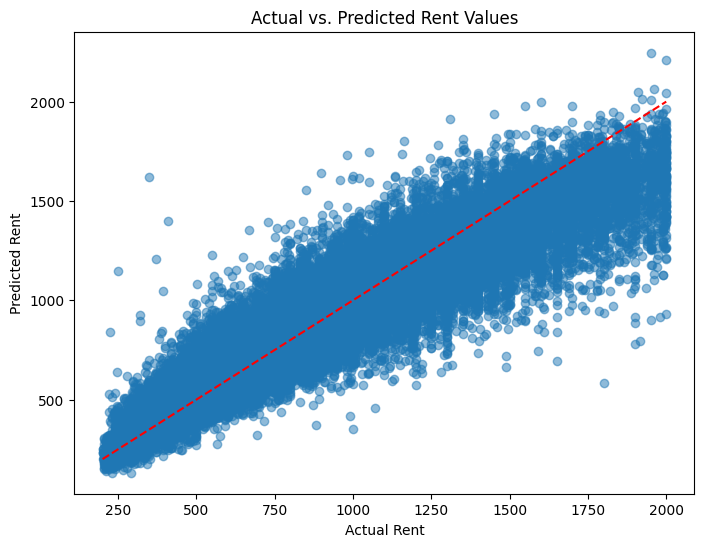

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')  # Diagonal line
plt.title('Actual vs. Predicted Rent Values')
plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.show()

for all Models side by side

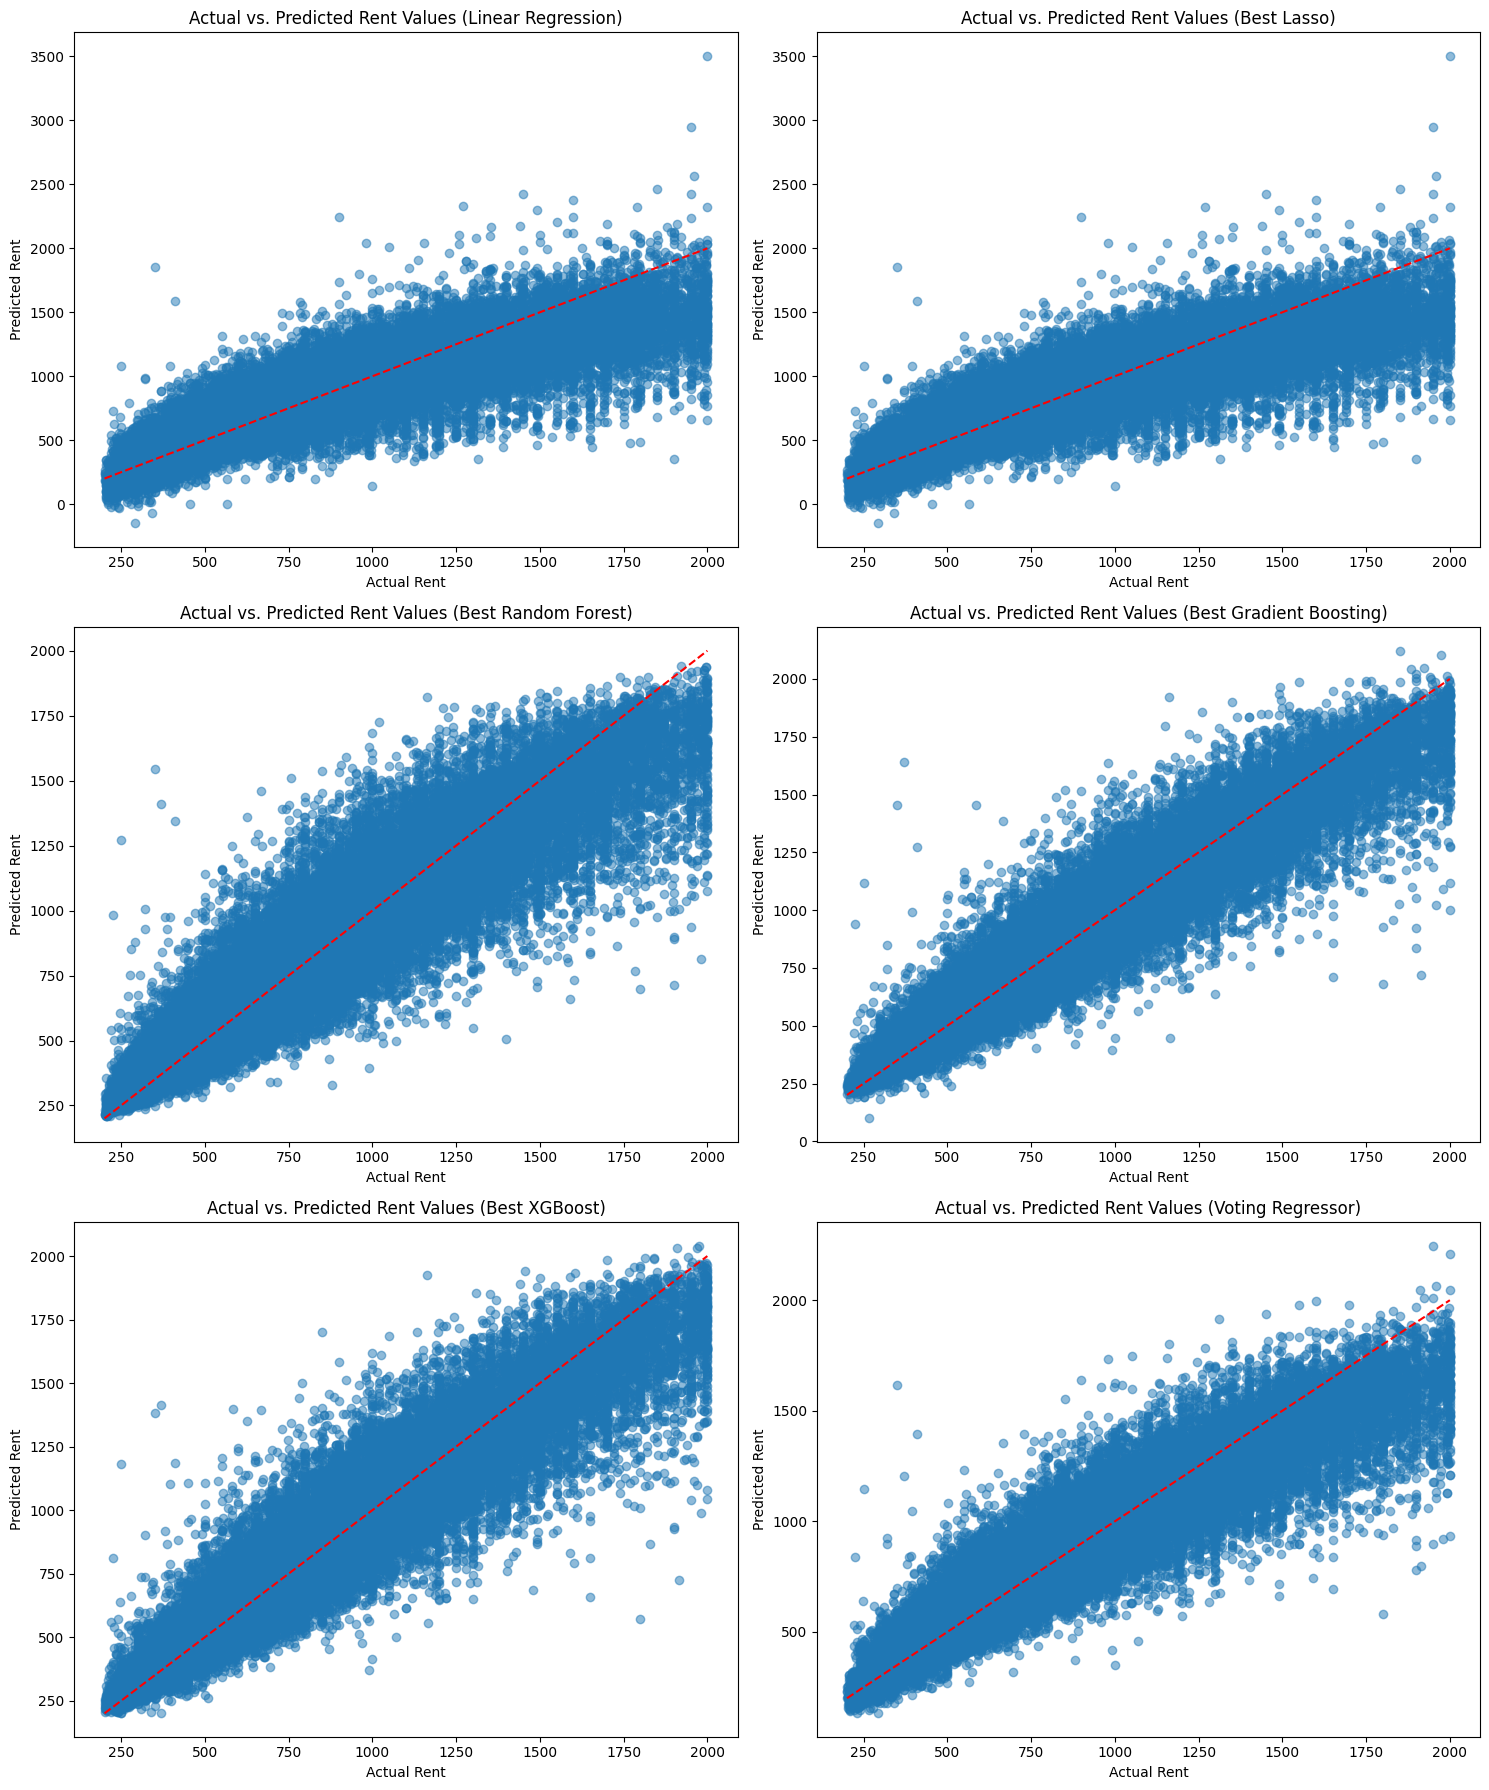

In [27]:
# Predict using each model
y_pred_lr = lr.predict(X_test)
y_pred_lasso = best_lasso.predict(X_test)
y_pred_rf = best_rf.predict(X_test)
y_pred_gb = best_gb.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)
y_pred_voting = voting_regressor.predict(X_test)

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Plot for Linear Regression
axes[0, 0].scatter(y_test, y_pred_lr, alpha=0.5)
axes[0, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
axes[0, 0].set_title('Actual vs. Predicted Rent Values (Linear Regression)')
axes[0, 0].set_xlabel('Actual Rent')
axes[0, 0].set_ylabel('Predicted Rent')

# Plot for Best Lasso
axes[0, 1].scatter(y_test, y_pred_lasso, alpha=0.5)
axes[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
axes[0, 1].set_title('Actual vs. Predicted Rent Values (Best Lasso)')
axes[0, 1].set_xlabel('Actual Rent')
axes[0, 1].set_ylabel('Predicted Rent')

# Plot for Best Random Forest
axes[1, 0].scatter(y_test, y_pred_rf, alpha=0.5)
axes[1, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
axes[1, 0].set_title('Actual vs. Predicted Rent Values (Best Random Forest)')
axes[1, 0].set_xlabel('Actual Rent')
axes[1, 0].set_ylabel('Predicted Rent')

# Plot for Best Gradient Boosting
axes[1, 1].scatter(y_test, y_pred_gb, alpha=0.5)
axes[1, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
axes[1, 1].set_title('Actual vs. Predicted Rent Values (Best Gradient Boosting)')
axes[1, 1].set_xlabel('Actual Rent')
axes[1, 1].set_ylabel('Predicted Rent')

# Plot for Best XGBoost
axes[2, 0].scatter(y_test, y_pred_xgb, alpha=0.5)
axes[2, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
axes[2, 0].set_title('Actual vs. Predicted Rent Values (Best XGBoost)')
axes[2, 0].set_xlabel('Actual Rent')
axes[2, 0].set_ylabel('Predicted Rent')

# Plot for Voting Regressor
axes[2, 1].scatter(y_test, y_pred_voting, alpha=0.5)
axes[2, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
axes[2, 1].set_title('Actual vs. Predicted Rent Values (Voting Regressor)')
axes[2, 1].set_xlabel('Actual Rent')
axes[2, 1].set_ylabel('Predicted Rent')

plt.tight_layout()
plt.show()


## Residuals Plots
A residuals plot helps you evaluate the goodness of fit of a regression model. Ideally, the Voting Regressor should have the most evenly scattered residuals around zero, indicating it’s capturing the patterns in the data well.



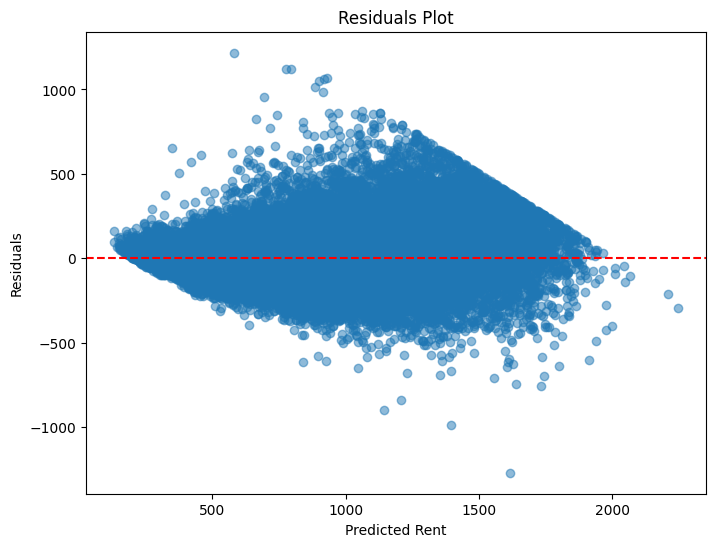

In [28]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
plt.title('Residuals Plot')
plt.xlabel('Predicted Rent')
plt.ylabel('Residuals')
plt.show()


Overall, the ensemble model seems to perform reasonably well, but there are areas (especially at higher rent values) where further refinement could improve predictions.

Centering Around Zero:

Ideal Behavior: In a well-fitted model, the residuals should be centered around zero. This plot shows that most residuals are close to the red dashed line (y=0), which is good.

Spread of Residuals:

Even Spread: An ideal residuals plot will have a consistent spread across all predicted values. In our plot, the spread of residuals increases with higher predicted rent values. This means the model's errors tend to be larger for higher rent predictions.

Patterns:

Non-random Patterns: If there's a clear pattern (like a funnel shape or curve), it indicates the model isn't capturing all the underlying trends in the data. In our plot, there seems to be a slight increase in variance as the predicted rent increases, but no obvious pattern indicating a severe issue.

Outliers:

High Residuals: There are some points with very high residuals (both positive and negative). These could be outliers or cases where the model performs poorly. Examining these points in more detail could help understand where the model fails.

Heteroscedasticity:

Variance of Residuals: If the spread of residuals increases with predicted values (as seen here), it indicates heteroscedasticity, meaning the model's error variance changes with the level of the predicted variable. This can suggest the need for different modeling techniques or transformations to handle the variance better.

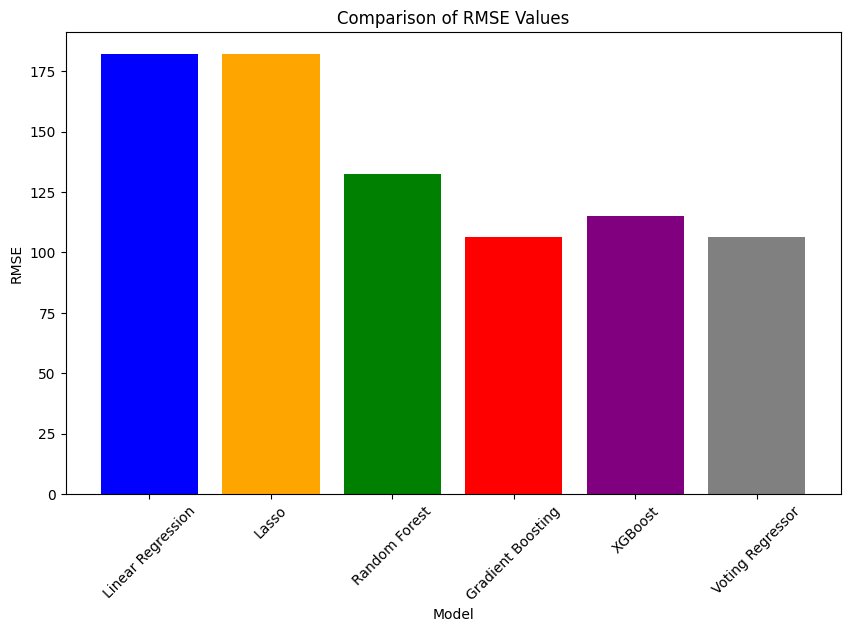

In [29]:
models = ['Linear Regression', 'Lasso', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'Voting Regressor']
rmse_values = [rmse_lr, rmse_lasso, rmse_rf, rmse_gb, rmse_xgb, rmse]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['blue', 'orange', 'green', 'red', 'purple', 'gray'])
plt.title('Comparison of RMSE Values')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

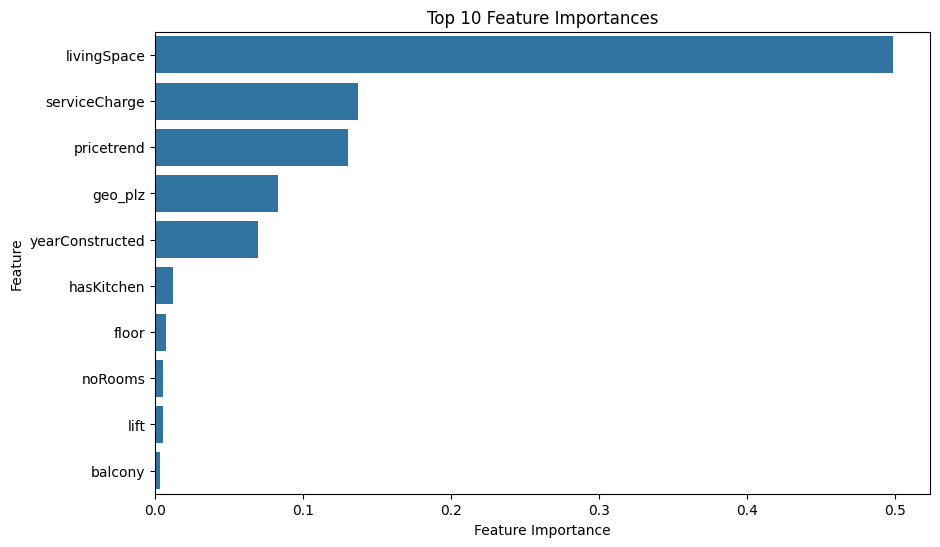

In [30]:
# Check if the model inside the pipeline has feature importances
if hasattr(best_rf.named_steps['model'], 'feature_importances_'):
    feature_importances = best_rf.named_steps['model'].feature_importances_
    sorted_indices = np.argsort(feature_importances)[::-1]  # Sort indices in descending order
    
    # Create a list of feature names
    preprocessor_features = numerical_cols + list(best_rf.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols)) + bool_columns
    top_features = [preprocessor_features[i] for i in sorted_indices][:10]  # Display top 10 features

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances[sorted_indices][:10], y=top_features)
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.show()
else:
    print("The model does not have feature importances attribute.")


## Hyperparameter Tuning Curves
Each subplot shows the relationship between a specific hyperparameter and the model's performance, typically measured using a metric such as the negative mean squared error (MSE).

The plots illustrate the results of hyperparameter tuning for four different models: Lasso, Random Forest, Gradient Boosting, and XGBoost. Here's an analysis and explanation of each subplot:

### Lasso Hyperparameter Tuning Curve:
- The plot shows the relationship between the alpha parameter (regularization strength) of the Lasso regression model and the negative mean squared error (MSE).
- As the value of alpha increases, the negative MSE also increases, indicating higher prediction error. This suggests that higher regularization leads to less overfitting but may increase bias.
- Interpretation: The optimal alpha value appears to be the lowest tested value, as increasing alpha leads to higher errors. This implies that minimal regularization is preferable for this model.

### Random Forest Hyperparameter Tuning Curves:
- **Number of Estimators vs. Max Depth:** This plot illustrates the effect of the number of estimators (decision trees) in the Random Forest model on the negative MSE for different max depth values.
  - Interpretation: Increasing the number of estimators generally decreases the negative MSE, but the max depth has a significant impact, with shallower trees (e.g., max depth 10) performing worse compared to deeper trees.
- **Number of Estimators vs. Min Samples Split:** This plot shows the impact of the number of estimators on the negative MSE for different min samples split values.
  - Interpretation: The min samples split value of 2 generally yields the best performance, indicating that the model benefits from splitting nodes with fewer samples.
- **Number of Estimators vs. Min Samples Leaf:** This plot shows how the negative MSE changes with the number of estimators for different min samples leaf values.
  - Interpretation: A min samples leaf value of 1 generally performs best, suggesting that allowing splits that create smaller leaf nodes can help improve model performance.

### Gradient Boosting Hyperparameter Tuning Curves:
- **Number of Estimators vs. Learning Rate:** The plot demonstrates the impact of the number of estimators on the negative MSE for different learning rates in the Gradient Boosting model.
  - Interpretation: Lower learning rates (e.g., 0.01) benefit more from increased estimators, showing a steady decrease in negative MSE. Higher learning rates converge more quickly but might miss finer improvements.
- **Number of Estimators vs. Max Depth:** This plot shows the relationship between the number of estimators and the negative MSE for different max depth values.
  - Interpretation: Deeper trees (e.g., max depth 7 or 9) generally perform better, with more significant improvements seen as the number of estimators increases, indicating the model's ability to capture more complex relationships.

### XGBoost Hyperparameter Tuning Curves:
- **Number of Estimators vs. Learning Rate:** This subplot shows how the negative MSE changes with the number of estimators for different learning rates in the XGBoost model.
  - Interpretation: Lower learning rates (e.g., 0.01) show significant improvements with more estimators, while higher rates (e.g., 0.2) converge quickly but may not perform as well in the long run.
- **Number of Estimators vs. Max Depth:** This subplot shows the relationship between the number of estimators and the negative MSE for different max depth values.
  - Interpretation: Models with greater depth (e.g., max depth 7 or 9) tend to perform better with increasing estimators, indicating the benefit of capturing deeper, more complex patterns.

Overall, these plots provide valuable insights into how different hyperparameters affect model performance. They help in selecting the optimal hyperparameter values that minimize prediction error and improve the generalization ability of the models.


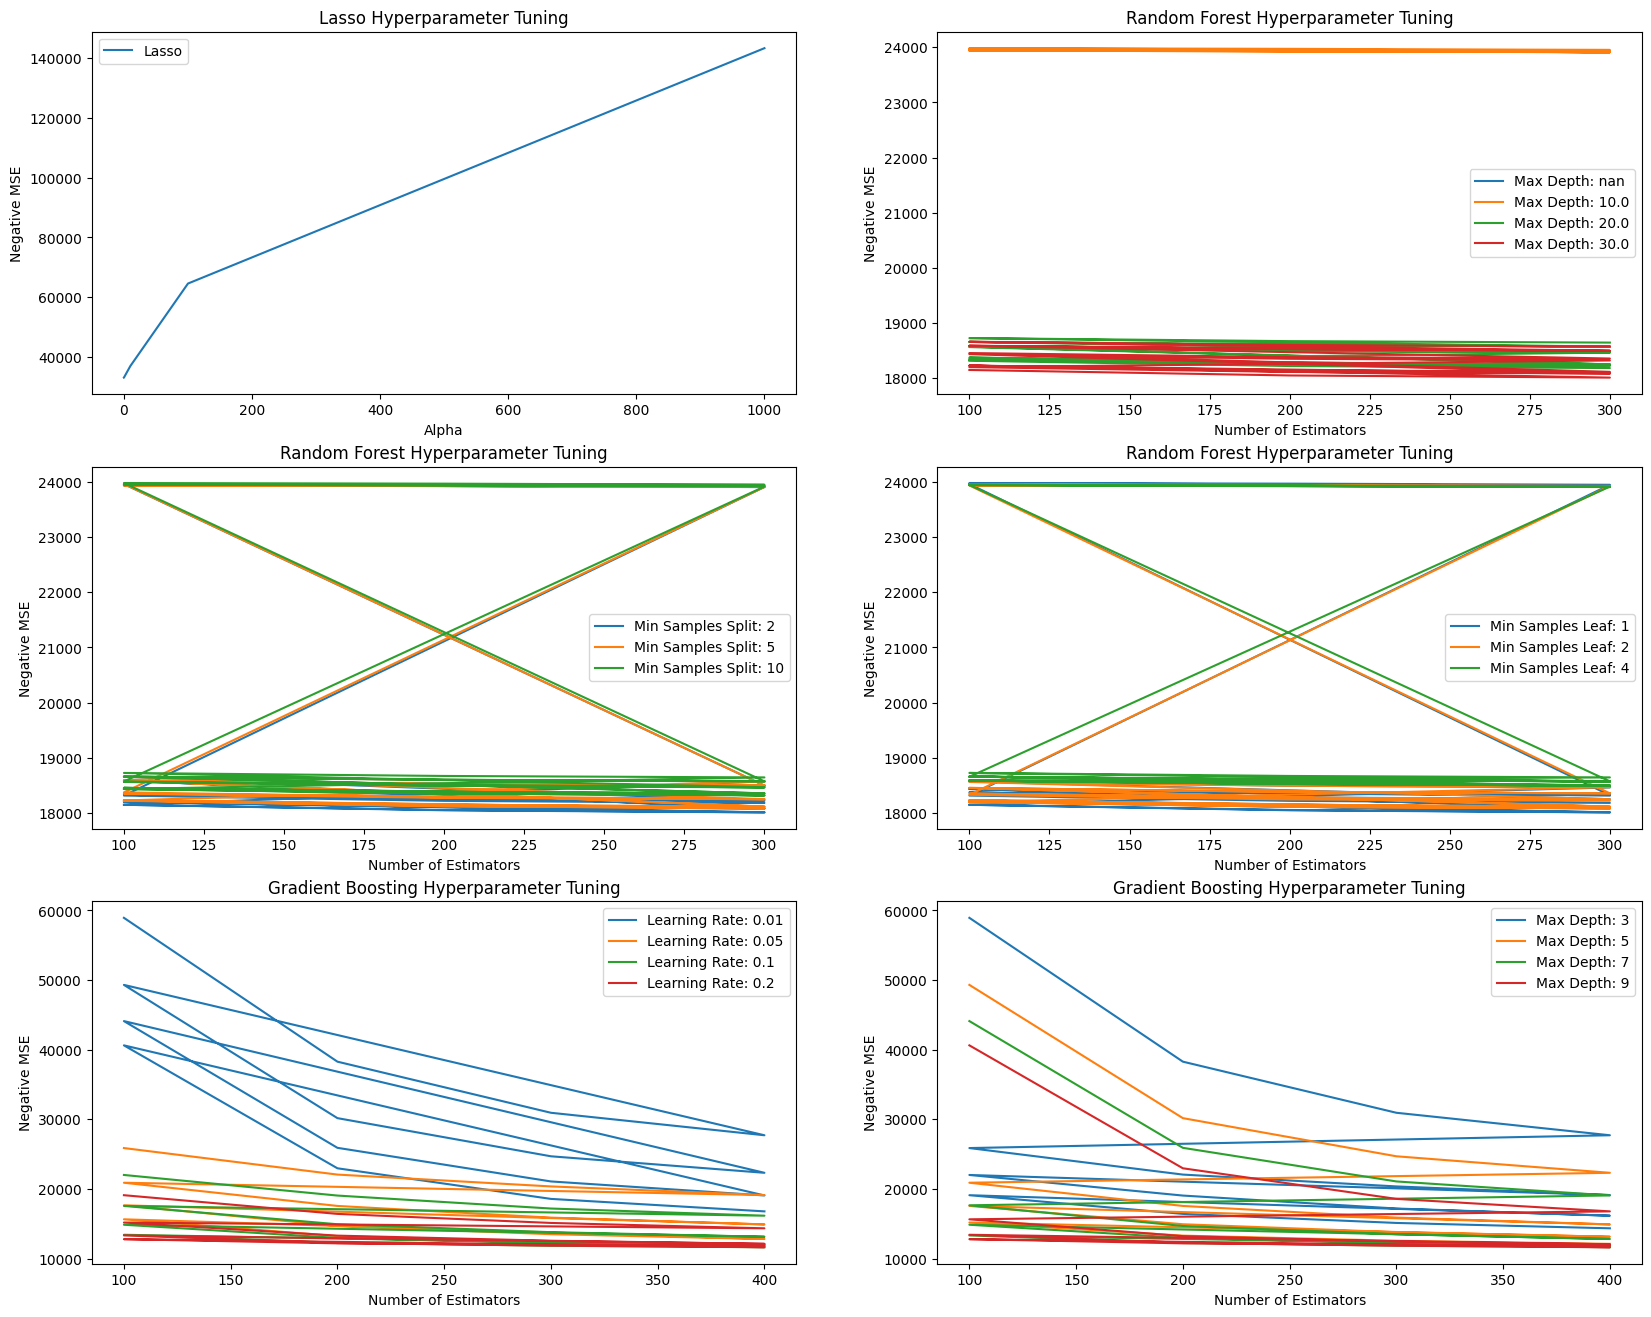

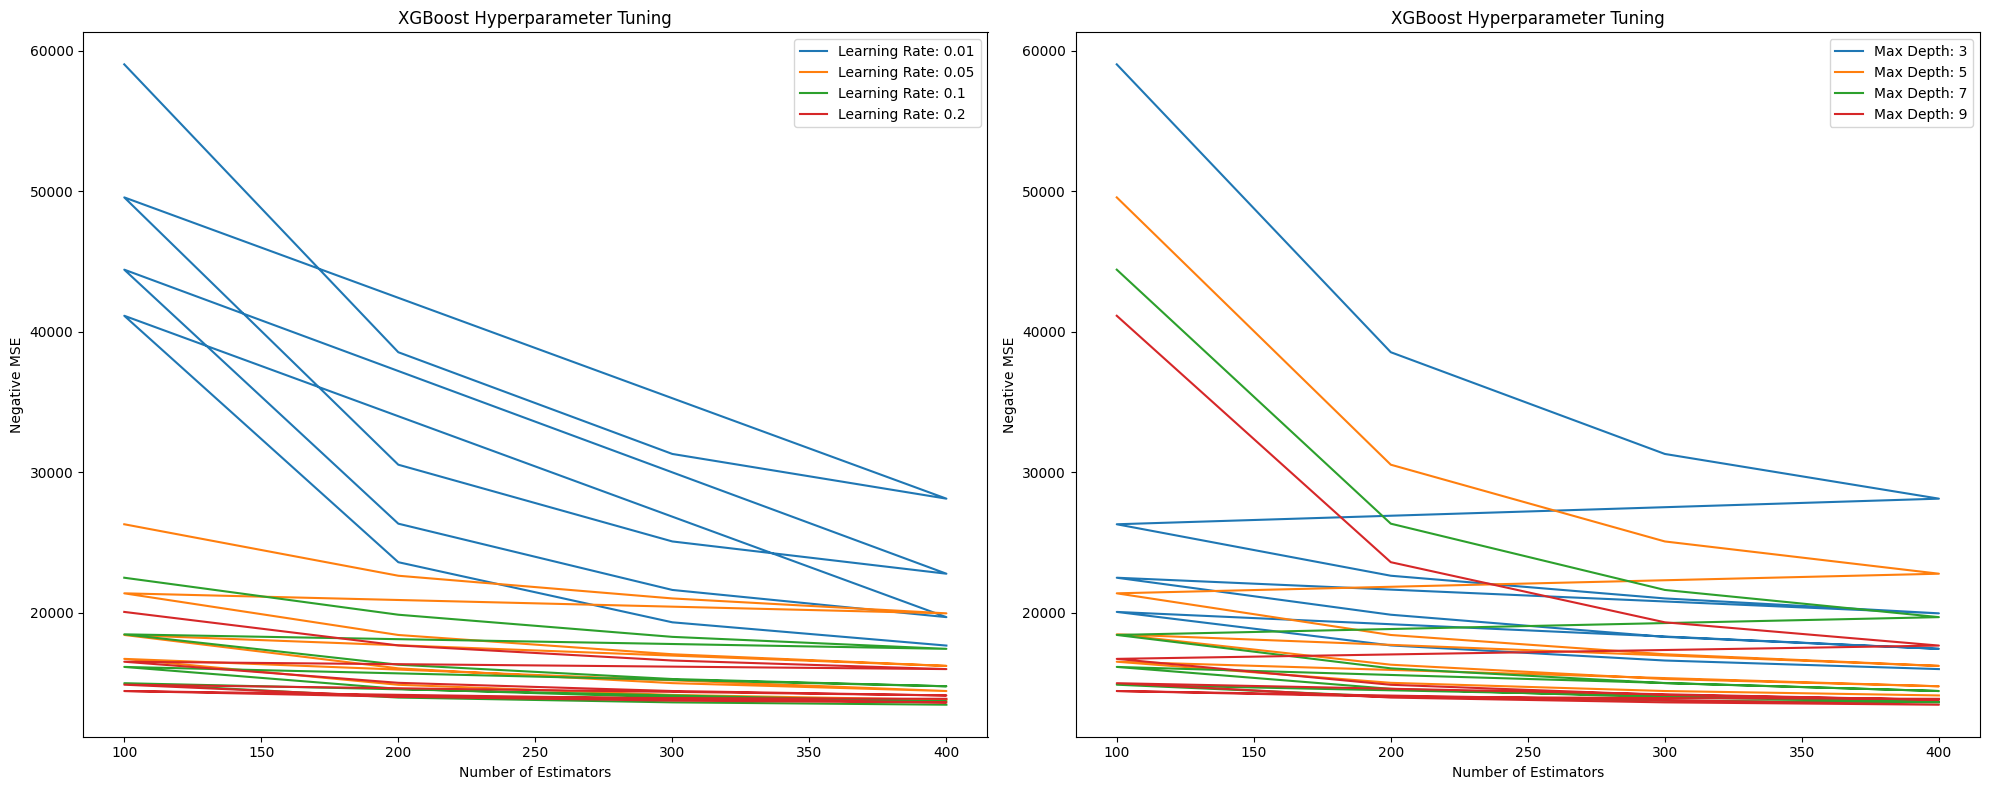

In [31]:
# Extract grid search results
lasso_results = pd.DataFrame(grid_search_lasso.cv_results_)
rf_results = pd.DataFrame(grid_search_rf.cv_results_)
gb_results = pd.DataFrame(grid_search_gb.cv_results_)
xgb_results = pd.DataFrame(grid_search_xgb.cv_results_)

# Plot grid search results
plt.figure(figsize=(20, 16))

# Lasso
plt.subplot(3, 2, 1)
plt.plot(lasso_results['param_model__alpha'], -lasso_results['mean_test_score'], label='Lasso')
plt.title('Lasso Hyperparameter Tuning')
plt.xlabel('Alpha')
plt.ylabel('Negative MSE')
plt.legend()

# Random Forest
plt.subplot(3, 2, 2)
for depth in rf_results['param_model__max_depth'].unique():
    subset = rf_results[rf_results['param_model__max_depth'] == depth]
    plt.plot(subset['param_model__n_estimators'], -subset['mean_test_score'], label=f'Max Depth: {depth}')
plt.title('Random Forest Hyperparameter Tuning')
plt.xlabel('Number of Estimators')
plt.ylabel('Negative MSE')
plt.legend()

plt.subplot(3, 2, 3)
for min_samples_split in rf_results['param_model__min_samples_split'].unique():
    subset = rf_results[rf_results['param_model__min_samples_split'] == min_samples_split]
    plt.plot(subset['param_model__n_estimators'], -subset['mean_test_score'], label=f'Min Samples Split: {min_samples_split}')
plt.title('Random Forest Hyperparameter Tuning')
plt.xlabel('Number of Estimators')
plt.ylabel('Negative MSE')
plt.legend()

plt.subplot(3, 2, 4)
for min_samples_leaf in rf_results['param_model__min_samples_leaf'].unique():
    subset = rf_results[rf_results['param_model__min_samples_leaf'] == min_samples_leaf]
    plt.plot(subset['param_model__n_estimators'], -subset['mean_test_score'], label=f'Min Samples Leaf: {min_samples_leaf}')
plt.title('Random Forest Hyperparameter Tuning')
plt.xlabel('Number of Estimators')
plt.ylabel('Negative MSE')
plt.legend()

# Gradient Boosting
plt.subplot(3, 2, 5)
for lr in gb_results['param_model__learning_rate'].unique():
    subset = gb_results[gb_results['param_model__learning_rate'] == lr]
    plt.plot(subset['param_model__n_estimators'], -subset['mean_test_score'], label=f'Learning Rate: {lr}')
plt.title('Gradient Boosting Hyperparameter Tuning')
plt.xlabel('Number of Estimators')
plt.ylabel('Negative MSE')
plt.legend()

plt.subplot(3, 2, 6)
for depth in gb_results['param_model__max_depth'].unique():
    subset = gb_results[gb_results['param_model__max_depth'] == depth]
    plt.plot(subset['param_model__n_estimators'], -subset['mean_test_score'], label=f'Max Depth: {depth}')
plt.title('Gradient Boosting Hyperparameter Tuning')
plt.xlabel('Number of Estimators')
plt.ylabel('Negative MSE')
plt.legend()

# XGBoost
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
for lr in xgb_results['param_model__learning_rate'].unique():
    subset = xgb_results[xgb_results['param_model__learning_rate'] == lr]
    plt.plot(subset['param_model__n_estimators'], -subset['mean_test_score'], label=f'Learning Rate: {lr}')
plt.title('XGBoost Hyperparameter Tuning')
plt.xlabel('Number of Estimators')
plt.ylabel('Negative MSE')
plt.legend()

plt.subplot(1, 2, 2)
for depth in xgb_results['param_model__max_depth'].unique():
    subset = xgb_results[xgb_results['param_model__max_depth'] == depth]
    plt.plot(subset['param_model__n_estimators'], -subset['mean_test_score'], label=f'Max Depth: {depth}')
plt.title('XGBoost Hyperparameter Tuning')
plt.xlabel('Number of Estimators')
plt.ylabel('Negative MSE')
plt.legend()

plt.tight_layout()
plt.show()

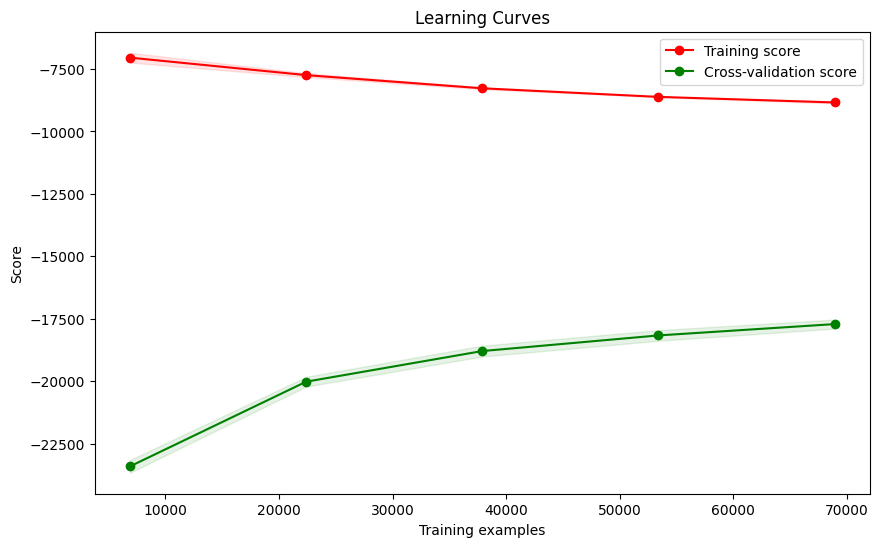

In [32]:
# Reduce data size by taking a subset of the data
X_subset = X.sample(frac=0.5, random_state=RSEED)
y_subset = y[X_subset.index]

# Reduce the number of cross-validation folds and training sizes
train_sizes, train_scores, test_scores = learning_curve(
    voting_regressor, X_subset, y_subset, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 5)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()